# A Journey to the Tip of Neural Networks

계속 핫한 숯같은 딥러닝, 그 기초 개념인 neural network을 알아보려고 한다. Neural network에 대해서 이래 저래 인터넷을 찾아봐도 잘 모르겠어서, 차근차근 [ESL](//github.com/dgkim5360/the-elements-of-statistical-learning-notebooks)을 통해 neural network를 알아가는 과정을 기록했다. Engineering 입장에서가 아닌 stat/math 입장에서 저술한 책으로, 좋은 평가를 받은 책으로 알고 있기 때문에, 출처는 믿을만 하다고 본다.

Supervised learning의 기본적인 개념 안에서 neural network를 설명할 수 있는 가장 기초적인 방법들부터 그 의미를 풀어나가고자 하는 것이 주 목적이다. 여기서 언급하는 각각의 방법론에 대한 설명은 각종 이론서에 굉장히 잘 설명이 되어 있을 것이기 때문에, "어떻게 계산하느냐"에 대해서는 설명을 최소화하려고 한다.

최대한 numpy/scipy 레벨에서 알고리즘을 코딩하려고 노력했으나 neural network는 PyTorch의 힘을 빌려서 진행할 것이다.

### Outline

1. Supervised Learning, Regression
  * Linear Regression
  * Basis Expansion
1. Supervised Learning, Classification
  * Linear Regression, Again
  * Logistic Regression
1. Finally, Neural Networks
  * Make It Simple, Stupid
  * Activation vs. Basis Expansion
  * Implementation with PyTorch

In [1]:
import csv
import scipy
import scipy.linalg
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Supervised Learning, Regression

Supervised learning 문제에서 우리가 알고 싶은 것은 주어진 input $X$와 output $Y$를 설명 (또는 예측)하는 $f$다. 그래서 $f$를 regression function이라고 부르기도 하고, 수학에서는 같은 문제를 function approximation이라는 이름으로 지칭한다.

\begin{equation}
Y = f(X)
\end{equation}

Training data $(\mathbf{X}, \mathbf{y})$를 가지고 $\hat{f}$을 계산한 뒤, 새로운 test data를 가져와 얘가 잘 맞추는 지 시험해보는 것이 supervised learning의 일반적인 개발 방법이다. 그렇다, supervised learning은 $\mathbf{y}$가 필요하다!

하지만 맨 땅에 헤딩으로 $\hat{f}$를 계산하는 것은 대단히 어려운 일이므로, 우리는 $f$가 무슨 특별한 성질을 가지고 있다고 가정을 해서 문제를 단순화해서 풀게 된다.

## Linear Regression

그 중에서 가장 얼토당토 않는 것이 $f$는 linear하다는 것이다. $X \in \mathbb{R}^p$이고 $Y \in \mathbb{R}$이라면 linear regression function은 아래와 같이 쓸 수 있다.

\begin{align}
Y &= f(X) \\
&= \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p \\
&= \beta^T X,
\end{align}

여기서 $X$와 $\beta$는 편의상 intercept를 포함하는 $(p+1)$-vector가 된다.
* $\beta^T = [\beta_0, \beta_1, \cdots, \beta_p]$,
* $X^T = [1, X_1, \cdots, X_p]$

그러면 이제 $f$을 추정하는 것은 $\beta$를 찾아내는 것과 같은 일이 된다.

지나치게 간략히 설명하자면 __linear regression은 자 대고 적당하게 긋는 거다__.

계산하는 방법은 여러 이론서에 굉장히 잘 설명되어 있을테니, least squares 방법을 사용한다고만 언급해두겠다.

(least squares에 관한 설명이 필요할 듯... loss function을 최소화하는 흐름)

### 1D Example

가장 간단하게 1D에서의 예제를 보겠다.

\begin{equation}
Y = \beta_0 + \beta_1 X
\end{equation}

Y = 0.098315 + 0.009675X


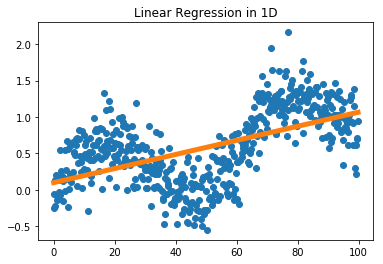

In [2]:
"""The simplest example for 1D linear regression"""
# Generate data (적당히 sine 모양으로 만들었음)
sample_size = 500
sample_x = scipy.arange(0, 100, 100/sample_size)
sample_y_true = scipy.sin(sample_x/10)/2 + sample_x*.01
sample_y = sample_y_true + scipy.randn(sample_size)/4

# Plot the data
fig0 = plt.figure(0)
ax0 = fig0.add_subplot(1, 1, 1)
ax0.plot(sample_x, sample_y, 'o')

# Implementation for the 1D linear regression
mat_1x = scipy.vstack((scipy.ones(sample_size), sample_x)).T
hat_beta = scipy.linalg.solve((mat_1x.T @ mat_1x),
                              (mat_1x.T @ sample_y))

# Compute the fit
hat_y = mat_1x @ hat_beta

# Plot the fit
ax0.plot(sample_x, hat_y, linewidth=5)
ax0.set_title('Linear Regression in 1D')
print('Y = {:5f} + {:5f}X'.format(*hat_beta))

위 그림을 봤을 때, 계산된 직선은 경우에 따라 괜찮기도 하고 안 괜찮기도 하다.
1. 주어진 데이터를 얼마나 잘 설명하는가? 나쁘다.  
  곡선을 그리는 데이터를 보고 "아 직선으로 맞추자" 했으니 애초에 모델을 잘 못 잡았다. (High bias)
2. 새로운 데이터가 왔을 때 얼마나 잘 맞추는가? 괜찮을 것 같다.  
  어설프게 다른 방법으로 좀 더 맞춰본다고 해봤자, 그것이 test 상황에서 도움이 될지는 해보기 전까지는 모르는 일이다. 근데 아마 직선이 가장 안전하지 않을까? (Low variance)

위 예제는 정확하게 sin 함수를 기반으로 실험실 (나의 jupyter notebook)에서 생성한 데이터였기 때문에 새로운 데이터를 예측하는 데 안 좋을 수도 있다고 생각이 들 수 있다. 하지만 $Y=f(X)$로 정확한 관계가 있는 데이터는 현실적으로 없다는 것을 생각해봤을 때, 결국 가장 안전한 예측선은 직선이라고 생각할 수 있다.

직선은 간단하다. __간단하다는 것은 좋은 것이다__.
* 계산이 쉬워지고,
* 해석을 쉽게 해준다. 그리고
* 데이터가 부족한 상황에서 빛을 발한다.

물론 Linear regression을 이용해서 직선만 계산할 수 있는 것은 아니다.

### Polynomial Regression

Linear regression을 이론서에서 굉장히 중요하게 다루는 이유 중 하나는 똑같은 방법을 이용해서 더 복잡한 식을 맞출 수 있기 때문이다.

그 원리는 간단하다. 우리가 구하고자 하는 2차 곡선을 표현하기 위해 본래 사용하던

\begin{equation}
Y = \beta_0 + \beta_1 X
\end{equation}

에다가 제곱 항을 하나 붙이면 된다.

\begin{equation}
Y = \beta_0 + \beta_1 X + \beta_2 X^2
\end{equation}

이에 따라 우리는 갖고 있는 input 자료에 제곱만 해서 붙여주고,

\begin{equation}
\mathbf{X} = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N
\end{bmatrix} \quad\Longrightarrow\quad
\mathbf{X} = \begin{bmatrix}
1 & x_1 & x_1^2 \\
1 & x_2 & x_2^2 \\
\vdots & \vdots & \vdots \\
1 & x_N & x_N^2
\end{bmatrix}
\end{equation}

그러면 $\hat\beta_0$, $\hat\beta_1$, $\hat\beta_2$를 구하는 위해서는 linear regression의 방법과 동일한 방법이면 충분하다.

Y = 0.422255 + -0.009839X + 0.000196X^2
Y = 0.644451 + -0.036691X + 0.000869X^2 + -0.000004X^3


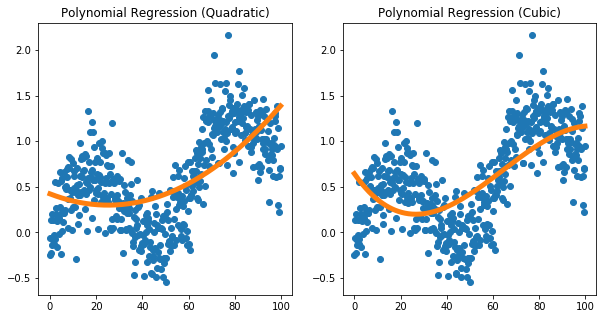

In [3]:
"""1D polynomial regression"""
# Plot the data
fig1 = plt.figure(1, figsize=(10, 5))
ax11 = fig1.add_subplot(1, 2, 1)
ax11.plot(sample_x, sample_y, 'o')
ax12 = fig1.add_subplot(1, 2, 2)
ax12.plot(sample_x, sample_y, 'o')

# Implementation for the 1D polynomial regression (quadratic/cubic)
mat_1x2 = scipy.vstack((scipy.ones(sample_size),
                        sample_x, sample_x*sample_x)).T
hat_beta2 = scipy.linalg.solve((mat_1x2.T @ mat_1x2),
                               (mat_1x2.T @ sample_y))
mat_1x3 = scipy.hstack((mat_1x2,
                        (sample_x*sample_x*sample_x).reshape(-1, 1)))
hat_beta3 = scipy.linalg.solve((mat_1x3.T @ mat_1x3),
                               (mat_1x3.T @ sample_y))

# Compute the fits
hat_y2 = mat_1x2 @ hat_beta2
hat_y3 = mat_1x3 @ hat_beta3

# Plot the fit
ax11.plot(sample_x, hat_y2, linewidth=5)
ax11.set_title('Polynomial Regression (Quadratic)')
ax12.plot(sample_x, hat_y3, linewidth=5)
ax12.set_title('Polynomial Regression (Cubic)')
print('Y = {:5f} + {:5f}X + {:5f}X^2'.format(*hat_beta2))
print('Y = {:5f} + {:5f}X + {:5f}X^2 + {:5f}X^3'.format(*hat_beta3))

Y = + 0.009952X + 0.504569sin(X)


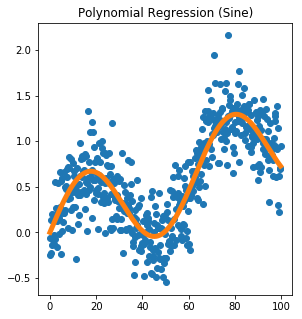

In [4]:
"""Bonus, this is never gonna happen in reality."""
# Plot the data
fig100 = plt.figure(100, figsize=(10, 5))
ax100 = fig100.add_subplot(1, 2, 1)
ax100.plot(sample_x, sample_y, 'o')

# Implementation for the 1D polynomial regression (quadratic/cubic)
mat_sinx = scipy.vstack((sample_x,
                         scipy.sin(sample_x/10))).T

hat_beta100 = scipy.linalg.solve((mat_sinx.T @ mat_sinx),
                                 (mat_sinx.T @ sample_y))

# Compute the fits
hat_y100 = mat_sinx @ hat_beta100

# Plot the fit
ax100.plot(sample_x, hat_y100, linewidth=5)
ax100.set_title('Polynomial Regression (Sine)')
print('Y = + {:5f}X + {:5f}sin(X)'.format(*hat_beta100))

따라서 2차 식 뿐만 아니라, 다항식의 차수를 계속 올려서 linear regression 방법을 이용해 추정값을 계산할 수 있을 것이다 (그래도 sine 함수는 맞추기 어렵다).

결국 linear regression은 어떤 변수가 오든지 ($X^2$가 오든 $e^X$가 오든) 각 변수의 linear coefficient를 계산하는 것만을 목적으로 한다. 이러한 개념이 basis expansion의 아이디어다.

## Basis Expansion

Input $X \in \mathbb{R}^p$를 무엇인가로 변환하는 것을 아래와 같이 함수로 이름 붙여놓으면

\begin{equation}
h: \mathbb{R}^p \mapsto \mathbb{R},
\end{equation}

$h$를 이용해서 linear basis expansion model를 표현할 수 있다.

\begin{equation}
f(X) = \sum_{m=1}^M \beta_m h_m(X)
\end{equation}

이해를 돕기 위해 몇 가지 예를 들어보겠다.

* 모든 $m$에 대해서 $h_m(X) = X_m$ 이라면 바로 linear regression model로 떨어진다.
* 위의 것에 더해서 2차/3차 .. 등등 고차 함수 항까지 넣어주면 polynomial regression이 된다.
* $\log X$, $\exp X$ 등의 nonlinear 변형도 넣고 싶으면 넣어도 된다.

이렇게 새로운 항을 추가할 수도 있겠지만 반대로 기존 정보를 제한시킬 수도 있다.

* $h_m(X) = I(L_m \le X_k \lt U_m)$을 사용하고 $L_m$와 $U_m$을 잘 설정하면, 기존 데이터를 구간 별로 잘라서 사용하는 효과를 가질 수 있다.

__그리고 이 모든 것들을 모두 합쳐도 된다__.

참고로 $I$는 indicator function으로, 조건에 따라 0 아니면 1을 갖게 된다.

\begin{equation}
I(\text{expression}) = \begin{cases}1 & \text{if expression is true}, \\ 0 & \text{otherwise}\end{cases}
\end{equation}

### 1D Example

굉장히 널리 쓰이는 Basis expansion 방법 중 하나인 natural cubic spline을 간단하게 설명하고 넘어가려 한다.

이름에서 알 수 있듯이 3차 곡선 함수로 모델을 맞추는 것이긴 한데 거기에 몇 가지 성질을 더 추가한다.
1. $X$의 영역을 잘라서 각각 3차 함수 fitting을 한다.  
  각 영역 경계를 나타내는 점들을 knot이라 한다.
1. knot에서의 예측값은 일치해야 한다.  
  knot에서의 1차, 2차 미분도 일치해야 한다.
1. Boundary knot 바깥쪽에서는 모델이 linear하다고 가정한다.

영역을 쪼개서 각 영역마다 3차 곡선을 맞추면서, 각 영역이 맞대는 지점에서 자연스러운 곡선을 연출하기 위해서 이런 제한이 더 걸리는 것이다. 또한 가장자리 상황에서는 fitting이 더욱 어려워지므로 가장 단순하게 직선임을 가정한다.

Natural cubic spline이 뭔지 아는 것도 중요하지만, __basis expansion을 통해서 내가 어떤 모델을 구성하든지 최종적으로는 linear regression으로 문제를 풀게 된다__는 흐름을 이해하는 것도 중요하다.

Text(0.5,1,'Natural Cubic Spline')

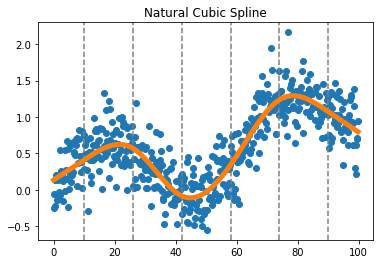

In [5]:
"""Natural cubic spline with 6 knots"""
def d(x: scipy.ndarray, knots: scipy.ndarray, k: int)->scipy.ndarray:
    return (scipy.where(x < knots[k], 0, (x-knots[k])**3)
            - scipy.where(x < knots[-1], 0, (x-knots[-1])**3))/(knots[-1]-knots[k])

# Construct H
knots = scipy.array([.1, .26, .42, .58, .74, .9])*100

h1 = scipy.ones_like(sample_x)
h2 = scipy.copy(sample_x)
h3 = d(sample_x, knots, 0) - d(sample_x, knots, -2)
h4 = d(sample_x, knots, 1) - d(sample_x, knots, -2)
h5 = d(sample_x, knots, 2) - d(sample_x, knots, -2)
h6 = d(sample_x, knots, 3) - d(sample_x, knots, -2)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

# Linear regression
hat_beta_spl = scipy.linalg.solve(H.T @ H, H.T @ sample_y)
hat_y_spl = H @ hat_beta_spl

# Plot
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(sample_x, sample_y, 'o')
y0, y1 = ax2.get_ylim()

for knot in knots:
    ax2.plot([knot, knot], [y0, y1], '--', color='gray')
ax2.set_ylim(y0, y1)
ax2.plot(sample_x, hat_y_spl, linewidth=5)
ax2.set_title('Natural Cubic Spline')

굉장히 훌륭한 추정 곡선을 볼 수 있다.

Basis expansion을 사용함에 있어서 어떤 $h_m$들을 쓸 것인가는 사용자가 직접 정해야 할 문제이고, 이는 꽤나 어려운 점이다. Natural cubic spline의 경우에도 3차 곡선을 사용한다고 정해져 있는 반면, knot의 위치는 내가 정해야 한다는 점을 알아두자.

# Supervised Learning, Classification

기본적으로 regression은 연속적(continuous)인 $Y$을 맞추고자 할 때 적합한 방법이다. 그렇다고 굳이 이산적(discrete) $Y$값을 쓰지 못할 것은 아니다.

이산적인 $Y$는 결국 분류(classification)의 문제로 이어진다. 예를 들어 주어진 데이터를 바탕으로 "사람이냐 동물이냐", "병에 걸렸냐 안 걸렸냐"를 추정하는 것은 "$Y$가 0이냐 1이냐"를 맞추는 것과 같은 것이다.

## Linear Regression, Again

아래는 y값이 0/1인 2D 예제이다. 데이터를 생성하고, 2D/3D에서의 시각화를 위한 코드 양이 많아서 길어지는데, 실제 linear regression을 계산하는 코드는 몇 줄 되지 않는다.

In [6]:
"""2D data with 0/1 response, an example for classification"""
def generate_data(sample_size: int)->tuple:
    """Reference: ESL Chapter 2"""
    # Parameters for mean distributions
    mean_blue = (1, 0)
    mean_orange = (0, 1)
    mean_cov = scipy.eye(2)*2
    mean_size = 10
    sample_size //= 2
    
    # Additional parameters for blue and orange distributions
    sample_cov = scipy.eye(2)/4
    
    # Generate mean components for blue and orange (10 means for each)
    sample_blue_mean = scipy.random.multivariate_normal(mean_blue,
                                                        mean_cov,
                                                        mean_size)
    sample_orange_mean = scipy.random.multivariate_normal(mean_orange,
                                                          mean_cov,
                                                          mean_size)
    
    # Generate blue points
    sample_blue = scipy.array([
        scipy.random.multivariate_normal(
            sample_blue_mean[scipy.random.randint(0, 10)],
            sample_cov
        ) for _ in range(sample_size)
    ])
    y_blue = scipy.zeros(sample_size)

    # Generate orange points
    sample_orange = scipy.array([
        scipy.random.multivariate_normal(
            sample_orange_mean[scipy.random.randint(0, 10)],
            sample_cov
        ) for _ in range(sample_size)
    ])
    y_orange = scipy.ones(sample_size)

    data_x = scipy.concatenate((sample_blue, sample_orange), axis=0)
    data_y = scipy.concatenate((y_blue, y_orange))
    return data_x, data_y

In [7]:
sample_size = 200
sample_x, sample_y = generate_data(sample_size)
sample_blue = sample_x[sample_y == 0, :]
sample_orange = sample_x[sample_y == 1, :]

Text(0.5,0.92,'0/1 Response in 3D View')

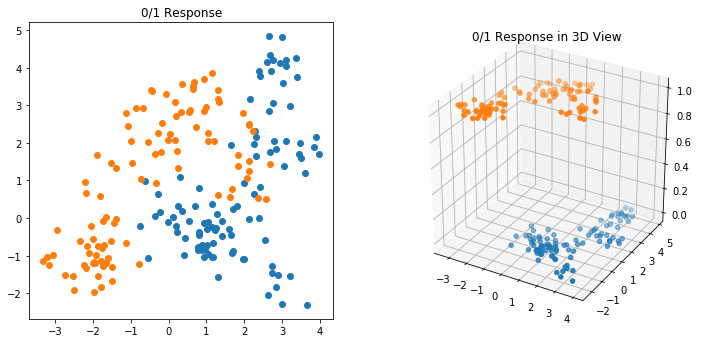

In [8]:
"""Plot the data"""
fig3 = plt.figure(3, figsize=(12, 12))
ax31 = fig3.add_subplot(2, 2, 1)
ax31.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax31.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')
ax31.set_title('0/1 Response')

fig3_x_min, fig3_x_max = ax31.get_xlim()
fig3_y_min, fig3_y_max = ax31.get_ylim()

ax32 = fig3.add_subplot(2, 2, 2, projection='3d')
ax32.scatter(sample_blue[:, 0], sample_blue[:, 1], 0, 'o', color='C0')
ax32.scatter(sample_orange[:, 0], sample_orange[:, 1], 1, 'o', color='C1')
ax32.set_title('0/1 Response in 3D View')

In [9]:
"""2D Linear regression implementation"""
mat_1x = scipy.hstack((scipy.ones((sample_size, 1)), sample_x))

# Solve (X^T*X)b = X^T*y for b,
# which is more efficient than computing an inverse matrix
hat_beta = scipy.linalg.solve((mat_1x.T @ mat_1x), (mat_1x.T @ sample_y))

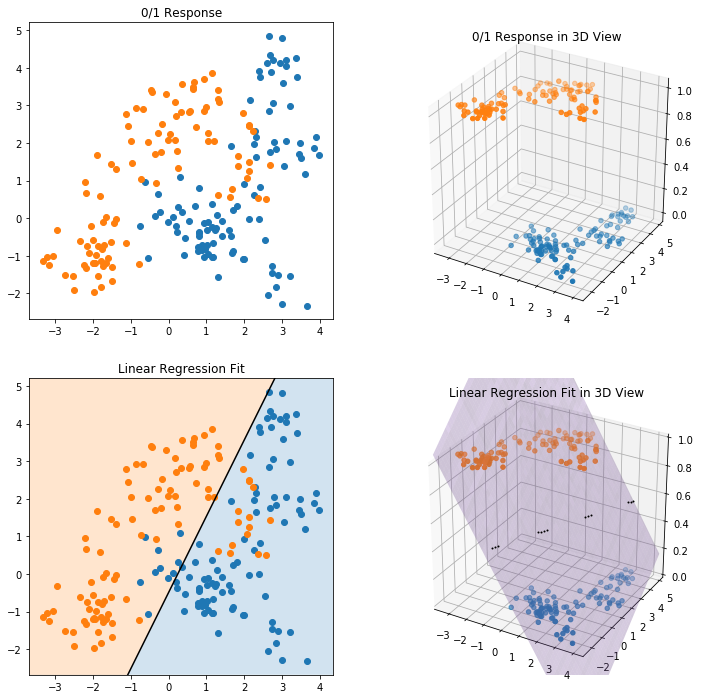

In [10]:
"""Plot the fit"""
ax33 = fig3.add_subplot(2, 2, 3)
ax33.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax33.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')

# Linear regression line for hat_y = 0.5
ols_line_y_min = (.5 - hat_beta[0] - fig3_x_min*hat_beta[1])/hat_beta[2]
ols_line_y_max = (.5 - hat_beta[0] - fig3_x_max*hat_beta[1])/hat_beta[2]
ax33.plot([fig3_x_min, fig3_x_max], [ols_line_y_min, ols_line_y_max], color='black')

# https://matplotlib.org/examples/pylab_examples/fill_between_demo.html
ax33.fill_between((fig3_x_min, fig3_x_max),
                  fig3_y_min,
                  (ols_line_y_min, ols_line_y_max),
                  facecolor='C0',
                  alpha=.2)
ax33.fill_between((fig3_x_min, fig3_x_max),
                  (ols_line_y_min, ols_line_y_max),
                  fig3_y_max,
                  facecolor='C1',
                  alpha=.2)
ax33.set_title('Linear Regression Fit')
ax33.set_xlim((fig3_x_min, fig3_x_max))
ax33.set_ylim((fig3_y_min, fig3_y_max))

ax34 = fig3.add_subplot(2, 2, 4, projection='3d')
ax34.scatter(sample_blue[:, 0], sample_blue[:, 1], 0, 'o', color='C0')
ax34.scatter(sample_orange[:, 0], sample_orange[:, 1], 1, 'o', color='C1')

gridx = scipy.linspace(fig3_x_min, fig3_x_max, 100)
gridy = scipy.linspace(fig3_y_min, fig3_y_max, 100)

meshx, meshy = scipy.meshgrid(gridx, gridy)
meshz = scipy.array([
    [hat_beta @ (1, colx, coly) for colx, coly in zip(rowx, rowy)]
    for rowx, rowy in zip(meshx, meshy)
])
linez = scipy.array([
    (x, y, z)
    for x, y, z in zip(meshx.flatten(), meshy.flatten(), meshz.flatten())
    if scipy.isclose(z, .5, rtol=0, atol=1e-3)
])
ax34.plot_surface(meshx, meshy, meshz, color='C4', alpha=.3)
ax34.plot(linez[:, 0], linez[:, 1], linez[:, 2], 'o',
          color='black', markersize=1)
ax34.set_xlim((fig3_x_min, fig3_x_max))
ax34.set_ylim((fig3_y_min, fig3_y_max))
ax34.set_zlim((0, 1))
ax34.set_title('Linear Regression Fit in 3D View')
fig3

* 3차원 평면이 실제 linear regression으로 맞춘(fit) 값이고,
* 검은 선은 그 값이 0.5인 선으로, BLUE의 영역인지 ORANGE의 영역인지를 구분하는 기준으로 삼았다.

### Indicator (Dummy) Variables

왜 0.5를 기준으로 분류하는가? $Y$가 0 또는 1을 가지므로 그 중간값을 기준으로 삼는 것은 꽤나 바람직해 보인다. 하지만 조금만 더 다양한 가능성을 생각해보자.

1. 우리의 3D 평면 fit을 봤을 때, 우리가 linear model을 통해 추정하는 $y$ 값은 0.3일 수도, -1.5일 수도, 120.123일 수도 있다. 그래도 0.5를 기준으로 분류해도 될까? 뭔가 꺼림칙하지만, linear model을 가정하고 있는 상황에서는 안 될 것도 없다고 볼 수 있다 (실제로 binary 분류 상황에서는 0-1 coding으로 문제를 단순화시킨다).
1. 그러면 $Y= 0, 1, 2$, 이렇게 세 가지 값을 갖는다고 해보자.  
  똑같은 논리로 우리는 0.5와 1.5를 기준으로 분류하는 것을 가장 쉽게 생각할 수 있다. 그리고 linear model을 통해 계산되는 값은 역시나 0.3일 수도, -1.5일 수도, 120.123일 수도 있다.  
  워, 그럼 문제가 굉장히 불공평해진다. $Y=1$을 결정하는 영역은 다른 영역에 비해 너무 좁은 것이다.

그래서 일반적으로는 여러 개의 $Y_k$ 변수를 두고 각 $Y_k$는 0과 1만을 갖는 indicator variable로 설정하게 된다.

\begin{align}
G = 0 & \Longrightarrow & (Y_1, Y_2, Y_3) = (1,0,0) \\
G = 1 & \Longrightarrow & (Y_1, Y_2, Y_3) = (0,1,0) \\
G = 2 & \Longrightarrow & (Y_1, Y_2, Y_3) = (0,0,1)
\end{align}

똑같은 training set $\mathbf{X}$가 있고 output data만 $\mathbf{y}_1$, $\mathbf{y}_2$, $\mathbf{y}_3$으로 늘어나는 것이므로 각각의 output에 대해서 똑같이 linear regression을 수행해주면 된다 (사실 matrix 계산으로 한 번에 된다).

그리고 어떤 data point에 대해서 계산된 예측값 $\hat{y}_1$, $\hat{y}_2$, $\hat{y}_3$을 갖게 될텐데, 이 중에서 가장 큰 값을 가지는 클래스로 분류하면 된다.

### Probability

Indicator 변수는 확률 개념을 끌어들인다.

\begin{equation}
\text{E}(Y_k|X=x) = \text{Pr}(G=k|X=x)
\end{equation}

하지만 지금까지 활약했던 linear model이 계산하는 추정값은 확률의 성질을 전혀 지키지 못하고 있다 (위에 3D 평면을 보라). 이를 보정해주고자 하는 방법이 logistic regression이다.

## Logistic Regression

### Logit Transform, Logistic Transform

밑도 끝도 없이 일단 logit 변환을 써 보겠다.

\begin{equation}
\text{logit}: (0,1) \mapsto \mathbb{R} \\
\text{logit}(p) = \log\frac{p}{1-p}
\end{equation}

Logit 변환은 monotone, continuous 하므로, 그 역함수(logistic function)도 마찬가지이다.

\begin{equation}
\text{logistic}: \mathbb{R} \mapsto (0,1) \\
\text{logistic}(a) = \frac1{1+\exp(-a)} = \frac{\exp(a)}{\exp(a)+1}
\end{equation}

아래 그래프를 보면 Logistic 변환은 실수를 확률처럼 만들어주는 데 적절한 변환임을 느낄 수 있다.

In [11]:
def logit(p:scipy.ndarray)->scipy.ndarray:
    return scipy.log(p/(1-p))


def logistic(a:scipy.ndarray)->scipy.ndarray:
    return scipy.reciprocal(1+scipy.exp(-a))

Text(0.5,1,'Logistic Function: Inverse of Logit')

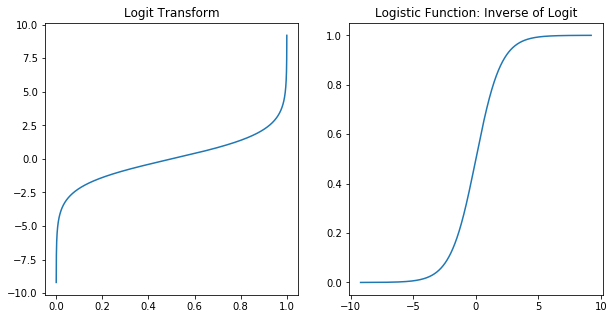

In [12]:
xgrid1 = scipy.linspace(0, 1, 10000, endpoint=False)[1:]
y_logitx = logit(xgrid1)

xgrid2 = y_logitx
y_logisticx = logistic(xgrid2)

fig5 = plt.figure(5, figsize=(10, 5))
ax51 = fig5.add_subplot(1, 2, 1)
ax51.plot(xgrid1, y_logitx)
ax51.set_title('Logit Transform')

ax52 = fig5.add_subplot(1, 2, 2)
ax52.plot(xgrid2, y_logisticx)
ax52.set_title('Logistic Function: Inverse of Logit')

### Formulation

Indicator 변수를 이용한 linear regression 문제를 표현하자면 다음과 같이 쓸 수 있다.

\begin{align}
\text{Pr}(G=1|X=x) &= \beta_{10} + \beta_{11} x \\
\text{Pr}(G=2|X=x) &= \beta_{20} + \beta_{21} x \\
&\vdots \\
\text{Pr}(G=K|X=x) &= \beta_{K0} + \beta_{K1} x \\
\end{align}

이 값들이 확률 개념을 만족시키지 못한다[고 지금까지 설명했다]. 그래서 보완을 하기 위해서 logistic transform이 끼어들게 된다.

\begin{align}
\text{logit } \text{Pr}(G=1|X=x) &= \beta_{10} + \beta_{11} x \\
\text{logit } \text{Pr}(G=2|X=x) &= \beta_{20} + \beta_{21} x \\
&\vdots \\
\text{logit } \text{Pr}(G=K-1|X=x) &= \beta_{(K-1)0} + \beta_{(K-1)1} x
\\
\text{Pr}(G=K|X=x) &= 1- \sum_{k=1}^{K-1}\text{Pr}(G=k|X=x)
\end{align}

이렇게 해서 logistic regression 문제로 도달하게 된다.

이제 $\beta$를 찾는 과정은 기존 least squares 방법보다는 복잡하게 바뀐다. Nonlinear 함수가 끼어들었기 때문에, loss를 최소화하기 위해서는 iterative하게 찾아다니게 된다.

In [13]:
"""Logistic regression

Please check any textbook for the detail of the algorithm
(I refer to the page 121 of ESL, Section 4.4)."""
def fvec_p(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    """Compute the vector p, the vector of fitted probabilties"""
    num = scipy.exp(mat_x@vec_beta)
    return num/(num+1)


def fdiag_W(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    """Compute the diagonal element of W"""
    vec_p = fvec_p(mat_x, vec_beta)
    return vec_p*(1-vec_p)

In [14]:
# initialization for iteration
lg_size_beta = 3
lg_hat_beta = scipy.zeros(lg_size_beta)
lg_beta_increment = scipy.ones(lg_size_beta)

# Newton-Raphson iteration
while (lg_beta_increment*lg_beta_increment).sum() > 1e-8:
    vec_p = fvec_p(mat_1x, lg_hat_beta)
    gradient = mat_1x.T @ (sample_y-vec_p)
    hessian = mat_1x.T @ scipy.diag(fdiag_W(mat_1x, lg_hat_beta)) @ mat_1x

    try:
        lg_beta_increment = scipy.linalg.solve(hessian, gradient)
    except scipy.linalg.LinAlgError:
        break
    
    lg_hat_beta += lg_beta_increment

Text(0.5,0.92,'Logistic Regression Fit in 3D View')

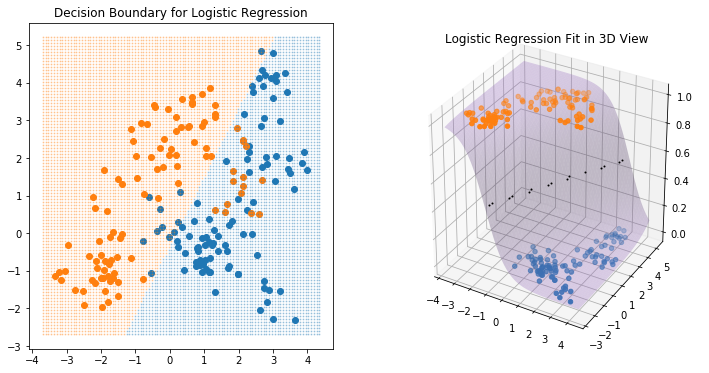

In [15]:
# Plot and compare
gridpair = scipy.array([[1, x, y]
                        for x in gridx
                        for y in gridy])
lg_z_pred = logistic(gridpair @ lg_hat_beta)
lg_pred = scipy.where(lg_z_pred > .5, 1, 0)

fig4 = plt.figure(4, figsize=(12, 6))
ax41 = fig4.add_subplot(1, 2, 1)
ax41.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax41.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')
ax41.plot(gridpair[lg_pred == 0, 1], gridpair[lg_pred == 0, 2], 'o',
          color='C0', alpha=.3, markersize=1)
ax41.plot(gridpair[lg_pred == 1, 1], gridpair[lg_pred == 1, 2], 'o',
          color='C1', alpha=.3, markersize=1)
ax41.set_title('Decision Boundary for Logistic Regression')

ax42 = fig4.add_subplot(1, 2, 2, projection='3d')
ax42.scatter(sample_blue[:, 0], sample_blue[:, 1], 0, 'o', color='C0')
ax42.scatter(sample_orange[:, 0], sample_orange[:, 1], 1, 'o', color='C1')

meshz = scipy.array([
    [lg_hat_beta @ (1, colx, coly) for colx, coly in zip(rowx, rowy)]
    for rowx, rowy in zip(meshx, meshy)
])
ax42.plot_surface(meshx, meshy, logistic(meshz), color='C4', alpha=.3)

linez = scipy.array([
    (x, y, z)
    for x, y, z in zip(meshx.flatten(), meshy.flatten(), meshz.flatten())
    if scipy.isclose(z, .5, rtol=0, atol=1e-2)
])
ax42.plot(linez[:, 0], linez[:, 1], linez[:, 2], 'o',
          color='black', markersize=1)
ax42.set_title('Logistic Regression Fit in 3D View')

우리가 삼고 있는 binary classification 문제의 경우, logistic regression은 0-1 사이에서의 아름다운 fit을 계산해주는 것을 볼 수 있다. 이제 0.5를 기준으로 맘 편하게 가르면 된다. 또한 그 결과로 도출되는 decision boundary의 linearity가 보존되어 있음을 볼 수 있다.

[다른 글](./why-is-logistic-regression-called-linear-method-kr.ipynb)에서 조금 더 자세한 설명을 볼 수 있다.

# Finally, Neural Networks

이제 neural network를 알아보기 위한 준비를 마쳤다. 그럼 다짜고짜 가장 간단한 형태인 single layer perceptron 모델을 써 보겠다.

\begin{align}
Z_m &= \sigma(\alpha_{0m} + \alpha_m^T X), & m=1,\cdots,M, \\
T_k &= \beta_{0k} + \beta_k^T Z, & k=1,\cdots,K, \\
Y_k &= f_k(X) = g_k(T), & k=1,\cdots,K.
\end{align}

여기서
* $Z$ 와 $T$는 각각 $Z_m$과 $T_k$들을 벡터로 모은 것이다:  
  $Z^T = [Z_1, \cdots, Z_M]$,  
  $T^T = [T_1, \cdots, T_K]$
* $\sigma$는 activation function,
* $g_k$는 output function이라고 부른다.
* Input layer $X$와 output layer $Y$ 사이의 $Z$는 hidden layer를 나타낸다.
* 각 layer의 변수 하나 하나를 unit이라고 부른다.

이 모델을 시각화한 도표와 함께 이해하려고 노력해보자. 검색만 하면 나오는 바로 그 거미줄이 나온다.

<img alt="schematic of a single hidden layer, feed-forward neural network", src="./fig11-2-neural-network.jpg" width="70%"/>

* 위에서 계속 다룬 single output regression 문제라면 output layer에는 $Y_1$ 하나만 있으면 된다.
* $K$-class classification 문제라면 output layer에는 indicator variable $Y_1, \cdots, Y_K$가 각 클래스에 속할 확률을 나타내게 된다.

이제 이 거미줄 얽어 놓은 것 같은 네트워크가 어떤 일을 하는 지 알아보겠다.

## Make It Simple, Stupid

위 도표를 보고 한 번에 neural network의 흐름을 이해하기는 나에겐 어려운 일이다. 상황을 단순화시켜서 생각해보면 우리가 이미 알고 있는 개념으로 연결된다고 한다. 이를 직접 확인해보자.

### No Activation Function $\Longrightarrow$ Linear Models

가장 먼저 $\sigma$를 날려보겠다.

\begin{equation}
\sigma(x) = x
\end{equation}

그러면 neural network 모델은 linear 모델로 확 단순해진다.

Output function $g$가 nonlinear하면 그게 아니지 않나 생각이 들 수도 있겠으나, output function은 그 이름처럼 output을 변환하는 것이지 input을 변환시키는 것이 아니다 ([logistic regression을 linear model로 분류하는 이유]()를 생각해보자).

#### $\Longrightarrow$ Linear regression

너무하다 싶을 정도로 다 쳐내볼까? 무려 hidden layer를 없애보자. 그냥 없애보자. 그리고 network의 구성이 어떻게 바뀌는 지 도표 상으로 계속 생각해보면 더 좋을 것 같다.

* Hidden layer 자체가 없다고 가정하면 $\beta$가 날라간다.
* Output layer의 unit은 하나만 남겨놓자, $K=1$
* Output function도 날려버리자, $g(x) = x$

이제 모델은 정확히 linear regression 모델이 된다.

\begin{align}
T &= \alpha_0 + \alpha^T X, \\
Y &= f(X) = T
\end{align}

#### $\Longrightarrow$ Logistic regression

이제 output function $g$를 logistic function으로 추가하면 binary classification을 위한 logistic regression 모델이 된다.

\begin{align}
T &= \alpha_0 + \alpha^T X, \\
Y &= f(X) = g(T) = \frac{1}{1+\exp{(-T)}}
\end{align}

그리고 neural network 문맥에서는 logistic function을 sigmoid라고 부른다.

여기서 $K$를 살리면, $K$-class classification을 위한 logistic regression 모델이 된다.

\begin{align}
T_k &= \alpha_{0k} + \alpha_k^T X, & k=1,\cdots,K-1, \\
Y_k &= f_k(X) = g(T_k), & k=1,\cdots,K-1, \\
Y_K &= 1 - \sum_{k=1}^{K-1} Y_k
\end{align}

Softmax output을 사용해도 똑같은 모델을 얻을 수 있다는 점을 언급만 하고 넘어가겠다.

### Activation $\Longrightarrow$ Basis Expansion

Activation function이 없어지면 우리가 아는 단순한 모델로 되돌아 가는 것을 확인했고, 이제는 그 반대 방향을 확인해봐야 한다. Activation에 집중하기 위해 나머지 세팅은 최소한으로 줄이겠다.

* Activation function $\sigma$와 hidden unit 개수인 $M$은 이제 의미가 있으므로 살려준다.
* $K=1$, output function은 없다고 생각하자, $g(x) = x$

\begin{align}
Z_m &= \sigma(\alpha_{0m} + \alpha_m^T X), & m=1,\cdots,M, \\
T &= \beta_0 + \beta^T Z, \\
Y &= f(X) = T
\end{align}

위 모델에서 activation function $\sigma$가 하나로 정해져있다는 점을 제외하면, basis expansion 모델의 형태를 하고 있는 것을 알 수 있다. Hidden layer unit들은 기존 input unit들을 바탕으로 모델이 nonlinearity를 쫓아갈 수 있도록 만들어주는 역할을 한다고 생각할 수 있겠다 (그래서 $Z$를 "derived feature"라고도 부른다).

## Activation vs. Basis Expansion

Neural network 모델을 basis expansion에 어거지로 맞출라면 이렇게 생각하면 된다. Activation function $\sigma$와 $\alpha$를 무시하고 $Z_m$ 하나 하나가 $X^2$, $X^3$, 등등... 이라고 내가 직접 지정하는 것이다. 이걸 neural network 모델 입장에서 생각해보면 activation $\sigma$와 그 coefficients $\alpha$는 hidden unit 하나 하나마다 맞춰서 이미 값을 정해버리는 것과 같다. 내가 그렇게 정했는데 누가 태클을 걸든 무슨 상관? 이것이 basis expansion의 입장이다.

__Basis expansion이 애들 학원 10개 씩 굴리면서 스케쥴 관리하시는 강남 엄마라면, neural network는 시골 동네에서 될 대로 되라고 애들 냅두시는 분들과 같다__. Neural network에서 내가 정해야 하는 것은 무엇 무엇이 있나?
* Activation function $\sigma$,
* Hidden unit 개수 $M$,
* Output function $g_k$

생각보다 이 분도 신경 쓰시긴 하는 것 같다 ~~(부모님의 사랑이란)~~. Hidden unit를 $M$개로 정했다면, 이제 그 $M$개의 변수들은 시간에 따라 알아서 성장하게 된다. 다시 말하자면 iterative하게 (nonlinearity가 모델에 들어가는 이상 피할 수 없다) training하는 과정에서 $\alpha$ 값이 training data에 맞도록 계속 조정되는 것이다.

그 와중에 모델의 세밀한 세팅은
* activation, output function을 어떤 것으로 정하느냐,
* layer 사이에서 어떻게 이웃을 정해서 정보를 교환할 것인지 등

을 정해줌으로써 구현된다. MNIST 예제만 보더라도 network를 어떻게 짜느냐에 따라 천차만별의 결과가 나오게 된다.

$\beta$를 업데이트하는 것은 basis expansion이나 neural network나 모두 필요로 하는 기존의 learning 과정이라고 생각할 수 있다.

### Who wins?

~~그래서 엄마를 고를 수 있다면, 어느 엄마가 더 좋은가?~~

그게 아니고, 오히려 우리는 모델을 평가해야 하는 입장이므로, 어머니의 입장에서 생각해봐야 한다. 어느 정책이 좋은 정책일까?

자식새끼가 성공했다고 치자.

#### Basis expansion
강남 엄마는 분명한 공적이 있다. 자식새끼의 스케쥴 하나 하나 본인이 고르고 감독한 덕분에 성공한 것이다. 
* 변수 하나 하나를 직접 선택해야 한다.
* 그 선택의 근거는 주로 기존 data에 대한 사전 지식이나 통찰력에서 나온다. 이는 굉장히 어려운 일이다.
* 그만큼 모델의 의미는 명확하다. 내가 선택한 변수만큼의 의미를 가지고 있을 것이다, 아니  
  모델의 의미를 먼저 정하고 변수를 선택한다는 순서가 더 맞을 것 같다.
* 따라서 성공이든 실패하든, 그것은 순전히 내 탓이다.  
  다시 말하면 결과에 대해서 모델이 어디가 부족한지 어디가 잘 맞춘건지 알 수 있다.

#### Neural networks
시골 엄마는 어떨까? 자식새끼 성공하면 좋긴 좋은데, 뭐 때문에 성공한 건지 알 리가 없다. 부모가 잘 한건지, 자식이 알아서 잘 큰건지, 시골에 있었던게 도움이 되었던 건지?
* Hidden layer의 unit들은 내가 어떤 지시를 내릴 필요 없이, 주어진 data에 맞춰서 알아서 발전한다.
* 편하다. 물론 여러 가지 정해야 할 것이 있긴 하지만, basis expansion에 비할 바가 아니다.  
  여러 $M$을 설정해서 시험해보는 것과 여러 basis 조합을 설정해서 시험하는 것을 비교해 생각해보자.
* 그만큼 모델은 굉장히 불투명하다.

기존 확실한 관계식을 바탕으로 한 통계 학습 모델과 비교해 봤을 때, neural network의 blackbox 특성은 분명한 단점이다. 하지만 반대로 꽉 짜여진 모델에 반해 월등한 유연함 또한 굉장한 장점이다. 이미 세상에서 만연한 딥러닝 열풍이 증명하듯이 neural network의 가능성은 꽤나 검증된 것 같기도 하다. 그 유연함은 추후 real world 예제를 통해 보여드릴 수 있길 바란다.

## Implementation with PyTorch

굉장히 중요하게 다뤄야 할 내용 중 하나인 "그래서 neural network를 어떻게 훈련시키는가"에 대해서는 아예 설명하지 않기로 한다. linear regression 단계에서부터 loss 개념을 설명하지 않았기 때문에 이미 늦었다. 그것만으로도 이 정도 분량이 나오리라 생각하기 때문에, 필요하다면 따로 정리하는 게 좋을 것 같다.

그래도 코드는 계속된다. 아까 2D 예제를 끌고 와서 single layer perceptron을 훈련시켜 보겠다.

이런 의미에서 implementation 역시 유명한 라이브러리 중 하나인 PyTorch를 사용하려고 한다.

### Why PyTorch?

최대한 numpy/scipy 레벨에서 코딩하고자 하는 이유는
1. 외부 framework의 사용법을 알아야 하는 부담을 줄이고
1. learning 과정이 어떻게 계산되는지 말 대신 코드로라도 보이고자 함이다.  
  남에게 보여주는 목적도 있지만, 내 공부를 확실하게 하는 목적도 있다.

하지만 neural network의 경우, 어떤 activation/output function을 쓰느냐 등의 세팅에 따라 training 알고리즘을 만들어야 한다. Loss function의 gradient를 직접 구해야 하는 것이 귀찮았다 (그렇다, 내 공부를 확실하게 못 했다). 그래서 찾아낸 타협점이 PyTorch였다.

PyTorch의 핵심 모듈은 `torch`, `torch.autograd`, `torch.nn`이다. 
* `torch`에서는 기본적인 data type인 `Tensor`를 제공한다. `numpy.array`를 GPU support까지 받을 수 있도록 만들어진 tensor 라이브러리이다.  
  원한다면 `torch.Tensor`만 가지고 바로 neural network를 구현할 수도 있다. 그러려면 loss의 gradient를 직접 하면 된다.
* `torch.autograd`는 바로 그 일을 맡아서 해준다.  
  역시 여기까지만 사용해서 구현이 가능하다. 각종 activation, output function과 loss function을 직접 만들고, network 구축도 직접 하면 된다.
* `torch.nn`은 바로 그 일을 맡아서 해준다. NN(neural network)에서 필요한 각종 수학 개념을 모두 넣어놓았고, network 구축도 할 수 있도록 모듈 별로 조합할 수 있는 frame을 제공해준다.

아직 내 손으로 모든 계산을 못 하는 상황이므로 PyTorch에게 엎혀가 보려 한다. 지금까지 설명했던 것들을 눈으로 직접 보기 위해, 3가지 모델을 `torch.nn`까지 이용해서 간단하게 구현해보겠다.

1. Hidden layer 없이 linear regression을 그대로 재현
1. Hidden layer 없이 logistic regression을 그대로 재현
1. Hidden unit 6개, sigmoid activation + sigmoid output

In [16]:
import torch

In [17]:
# Constant variables
n, p, m, k = 200, 2, 6, 1
learning_rate = 1e-4
niter = 50000

# Training data for PyTorch
torch_x = torch.autograd.Variable(torch.from_numpy(sample_x).float())
torch_y = torch.autograd.Variable(torch.from_numpy(sample_y.reshape(-1, 1)).float(),
                                  requires_grad=False)

# Training models and their associated loss functions
model1 = torch.nn.Linear(p, k, bias=True)
lossfunc1 = torch.nn.MSELoss(size_average=False)

model2 = torch.nn.Sequential(
    torch.nn.Linear(p, k, bias=True),
    torch.nn.Sigmoid(),
)
lossfunc2 = torch.nn.BCELoss(size_average=False)

model3 = torch.nn.Sequential(
    torch.nn.Linear(p, m, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(m, k, bias=True),
    torch.nn.Sigmoid(),
)
lossfunc3 = torch.nn.BCELoss(size_average=False)

In [18]:
%%time
"""Neural network training"""
# 1. Linear regression
for epoch in range(niter):
    # Forward pass
    y_pred1 = model1(torch_x)
    
    # Compute loss
    loss1 = lossfunc1(y_pred1, torch_y)
    
    # Zero the gradients before running backward pass
    model1.zero_grad()
    
    # Backward pass
    loss1.backward()
    
    # Update the weights using gradient descent
    for param in model1.parameters():
        param.data -= learning_rate*param.grad.data

CPU times: user 4.47 s, sys: 418 ms, total: 4.89 s
Wall time: 4.66 s


In [19]:
%%time
# 2. Logistic regression
for epoch in range(niter):
    # Forward pass
    y_pred2 = model2(torch_x)
    
    # Compute loss
    loss2 = lossfunc2(y_pred2, torch_y)
    
    # Zero the gradients before running backward pass
    model2.zero_grad()
    
    # Backward pass
    loss2.backward()
    
    # Update the weights using gradient descent
    for param in model2.parameters():
        param.data -= learning_rate*param.grad.data

CPU times: user 6.42 s, sys: 534 ms, total: 6.95 s
Wall time: 6.68 s


In [20]:
%%time
# 3. Neural network with 6 hidden units
for epoch in range(niter):
    # Forward pass
    y_pred3 = model3(torch_x)
    
    # Compute loss
    loss3 = lossfunc3(y_pred3, torch_y)
    
    # Zero the gradients before running backward pass
    model3.zero_grad()
    
    # Backward pass
    loss3.backward()
    
    # Update the weights using gradient descent
    for param in model3.parameters():
        param.data -= learning_rate*param.grad.data

CPU times: user 49 s, sys: 1.49 s, total: 50.5 s
Wall time: 26.5 s


In [21]:
torchgrid = torch.autograd.Variable(torch.from_numpy(gridpair[:, 1:]).float(),
                                     requires_grad=False)
model1pred = model1(torchgrid)
model1out = scipy.where(model1pred.data.numpy() >= .5, 1, 0).flatten()

model2pred = model2(torchgrid)
model2out = scipy.where(model2pred.data.numpy() >= .5, 1, 0).flatten()

model3pred = model3(torchgrid)
model3out = scipy.where(model3pred.data.numpy() >= .5, 1, 0).flatten()

Text(0.5,0.92,'Neural Network in 3D View')

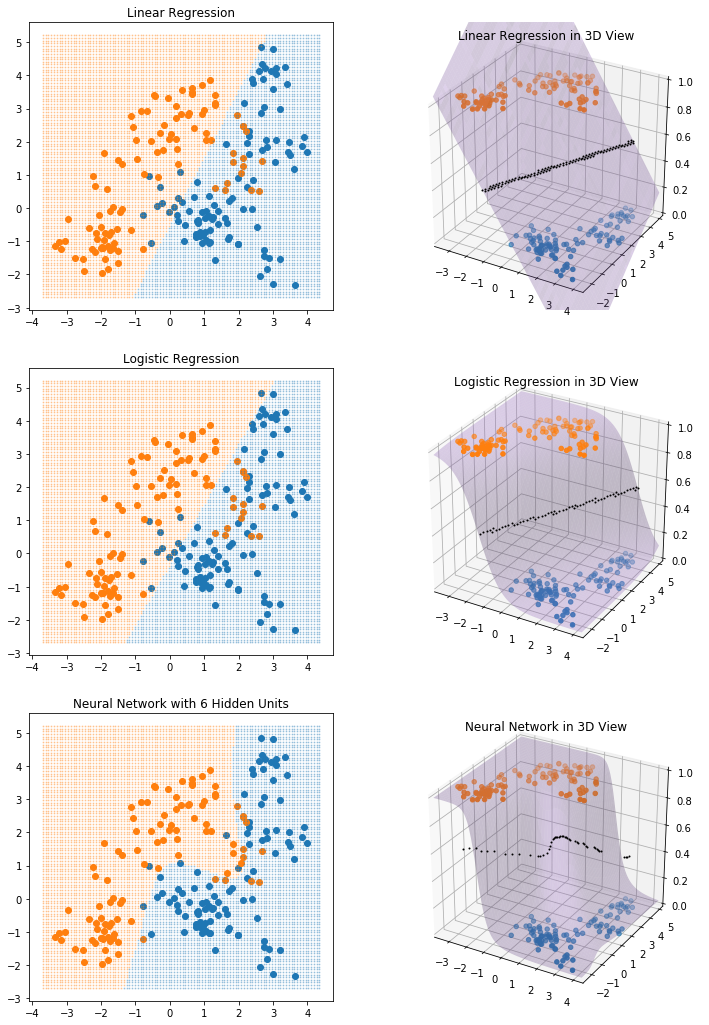

In [44]:
# Plot and compare
fig5 = plt.figure(5, figsize=(12, 18))
ax51 = fig5.add_subplot(3, 2, 1)

ax51.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax51.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')
ax51.plot(gridpair[model1out == 0, 1], gridpair[model1out == 0, 2], 'o',
          color='C0', alpha=.3, markersize=1)
ax51.plot(gridpair[model1out == 1, 1], gridpair[model1out == 1, 2], 'o',
          color='C1', alpha=.3, markersize=1)
ax51.set_title('Linear Regression via PyTorch')

ax52 = fig5.add_subplot(3, 2, 2, projection='3d')
ax52.scatter(sample_blue[:, 0], sample_blue[:, 1], 0, 'o', color='C0')
ax52.scatter(sample_orange[:, 0], sample_orange[:, 1], 1, 'o', color='C1')
meshz1 = model1pred.data.numpy().reshape(100, 100).T
ax52.plot_surface(meshx, meshy, meshz1, color='C4', alpha=.3)

linez1 = scipy.array([
    (x, y, z)
    for x, y, z in zip(meshx.flatten(), meshy.flatten(), meshz1.flatten())
    if scipy.isclose(z, .5, rtol=0, atol=1e-2)
])
ax52.plot(linez1[:, 0], linez1[:, 1], linez1[:, 2], 'o',
          color='black', markersize=1)

ax52.set_xlim((fig3_x_min, fig3_x_max))
ax52.set_ylim((fig3_y_min, fig3_y_max))
ax52.set_zlim((0, 1))
ax52.set_title('Linear Regression in 3D View')

ax53 = fig5.add_subplot(3, 2, 3)
ax53.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax53.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')
ax53.plot(gridpair[model2out == 0, 1], gridpair[model2out == 0, 2], 'o',
          color='C0', alpha=.3, markersize=1)
ax53.plot(gridpair[model2out == 1, 1], gridpair[model2out == 1, 2], 'o',
          color='C1', alpha=.3, markersize=1)
ax53.set_title('Logistic Regression via PyTorch')

ax54 = fig5.add_subplot(3, 2, 4, projection='3d')
ax54.scatter(sample_blue[:, 0], sample_blue[:, 1], 0, 'o', color='C0')
ax54.scatter(sample_orange[:, 0], sample_orange[:, 1], 1, 'o', color='C1')
meshz2 = model2pred.data.numpy().reshape(100, 100).T
ax54.plot_surface(meshx, meshy, meshz2, color='C4', alpha=.3)

linez2 = scipy.array([
    (x, y, z)
    for x, y, z in zip(meshx.flatten(), meshy.flatten(), meshz2.flatten())
    if scipy.isclose(z, .5, rtol=0, atol=1e-2)
])
ax54.plot(linez2[:, 0], linez2[:, 1], linez2[:, 2], 'o',
          color='black', markersize=1)

ax54.set_xlim((fig3_x_min, fig3_x_max))
ax54.set_ylim((fig3_y_min, fig3_y_max))
ax54.set_zlim((0, 1))
ax54.set_title('Logistic Regression in 3D View')

ax55 = fig5.add_subplot(3, 2, 5)
ax55.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax55.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')
ax55.plot(gridpair[model3out == 0, 1], gridpair[model3out == 0, 2], 'o',
          color='C0', alpha=.3, markersize=1)
ax55.plot(gridpair[model3out == 1, 1], gridpair[model3out == 1, 2], 'o',
          color='C1', alpha=.3, markersize=1)
ax55.set_title('Neural Network with 6 Hidden Units')

ax56 = fig5.add_subplot(3, 2, 6, projection='3d')
ax56.scatter(sample_blue[:, 0], sample_blue[:, 1], 0, 'o', color='C0')
ax56.scatter(sample_orange[:, 0], sample_orange[:, 1], 1, 'o', color='C1')
meshz3 = model3pred.data.numpy()
ax56.plot_surface(meshx, meshy, meshz3.reshape(100, 100).T, color='C4', alpha=.3)

linez3 = scipy.array([
    (x, y, z)
    for x, y, z in zip(meshx.flatten(), meshy.flatten(), meshz3.flatten())
    if scipy.isclose(z, .5, rtol=0, atol=1e-2)
])
ax56.plot(linez3[:, 0], linez3[:, 1], linez3[:, 2], 'o',
          color='black', markersize=1)

ax56.set_xlim((fig3_x_min, fig3_x_max))
ax56.set_ylim((fig3_y_min, fig3_y_max))
ax56.set_zlim((0, 1))
ax56.set_title('Neural Network in 3D View')


Neural network는 주어진 data에 맞춰서 그동안 보지 못했던 굉장한 decision boundary를 나에게 선사해 주었다. 하지만 training set에서 잘 맞춘 것과 test set에서 잘 하는 것은 완전 별개의 문제로, 우리가 알아야 할 이론적/실무적인 내용들이 굉장히 많이 있다.

나중에 더 알아보자.

여기까지 neural network가 어떤 방식으로 training하는 지 정리했다. 